In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import warnings
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import (
    OneHotEncoder
)

from feature_engine.encoding import RareLabelEncoder
from sklearn.compose import ColumnTransformer
from feature_engine.datetime import DatetimeFeatures

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from utils import eda_helper_functions
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.ensemble import IsolationForest
import sklearn

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import warnings

In [3]:
pd.set_option('display.max_columns',None)
sklearn.set_config(transform_output = "pandas")
warnings.filterwarnings("ignore")

In [4]:
training_data = pd.read_csv("../data/train_data.csv")
X_train = training_data.drop(columns = ['price'])
y_train = training_data.price

testing_data = pd.read_csv("../data/test_data.csv")
X_test = testing_data.drop(columns = ['price'])
y_test = testing_data.price

df1 = pd.DataFrame(y_train.to_list(),index = y_train.index,columns=['price'])
temp = pd.concat([X_train,df1],axis = 1)

temp["date"] = pd.to_datetime(temp.rename(columns={'dtoj_year': 'year', 
                                     'dtoj_month': 'month', 
                                     'dtoj_day': 'day'})[['year', 'month', 'day']])
temp.head(2)

,airline,source,destination,duration,total_stops,additional_info,dep_time_hour,dep_time_min,dtoj_day,dtoj_month,dtoj_year,price,date
0,Multiple Carriers,delhi,cochin,615,1,no info,15,15,6,6,2019,6795,2019-06-06
1,Jet Airways,kolkata,banglore,1220,1,in-flight meal not included,20,0,9,6,2019,10844,2019-06-09


### Airline Feature Engineering

In [5]:
airline_transformer = Pipeline(steps = [
    ("grouper",RareLabelEncoder(tol = 0.1,n_categories=2,replace_with="Other")),
    ("onehotencoding",OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
])
airline_transformer.fit_transform(temp[["airline"]]) # only accepts dataframe

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
6689,0.0,0.0,1.0,0.0,0.0
6690,0.0,0.0,0.0,0.0,1.0
6691,0.0,1.0,0.0,0.0,0.0
6692,0.0,0.0,0.0,0.0,1.0


### Date_of_Journey

In [6]:
dtoj_transformer = Pipeline(steps = [
    ("dt",DatetimeFeatures(features_to_extract = ['weekend'],yearfirst = True,format = "mixed"))
])

weekend = dtoj_transformer.fit_transform(temp[['date']])
temp = temp.assign(is_weekend = weekend)

# Dropping the dep_time_min column
temp.drop(columns=['dep_time_min'],inplace=True)

### Source and Destination

In [7]:
import sys
import os

# Add the parent directory (project root) to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.rbf import RouteCreator

In [8]:
from feature_engine.encoding import MeanEncoder
from sklearn.pipeline import Pipeline

route_map = {
    ("delhi", "cochin"): "1",
    ("kolkata", "banglore"): "2",
    ("mumbai", "hyderabad"): "3",
    ("bangalore", "newdelhi"): "4",
    ("bangalore", "delhi"): "5",
    ("chennai", "kolkata"): "6"
}

sor_des_trans = Pipeline(steps=[
    ("create_route", RouteCreator(route_map=route_map)),
    ("mean_encode_route", MeanEncoder(variables=["route"]))
])

sor_des_trans.fit_transform(temp[['source','destination']], temp['price'])

,route
0,10497.166667
1,9146.543996
2,7991.070822
3,7991.070822
4,10497.166667
...,...
6689,10497.166667
6690,10497.166667
6691,4737.041322
6692,9146.543996


In [9]:
# from feature_engine.encoding import MeanEncoder
# from sklearn.preprocessing import PowerTransformer

# sor_des_trans = Pipeline(steps = [
#     ("rarelabelencoding",RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
#     ("onehotencoding",OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
# ])

# sor_des_trans.fit_transform(temp[['source','destination']])

In [10]:
from sklearn.preprocessing import FunctionTransformer

north_cities = ['delhi','new delhi']

def is_north(temp):
    return(
        temp.assign(
            source_is_north =  lambda df_: np.select([df_.source.isin(north_cities)],[1],default=[0]),
            destination_is_north =  lambda df_: np.select([df_.destination.isin(north_cities)],[1],default=[0])
        )
        .drop(columns = ['source','destination'])
    )

FunctionTransformer(func=is_north).fit_transform(temp[["source","destination"]])

,source_is_north,destination_is_north
0,1,0
1,0,0
2,0,1
3,0,1
4,1,0
...,...,...
6689,1,0
6690,1,0
6691,0,0
6692,0,0


In [11]:
from sklearn.pipeline import FeatureUnion
source_destination_trans = FeatureUnion(transformer_list=[
    ("part1",sor_des_trans),
    ("part2",FunctionTransformer(func=is_north))
])

source_destination_trans.fit_transform(temp[['source','destination']],y = temp['price'])

,route,source_is_north,destination_is_north
0,10497.166667,1,0
1,9146.543996,0,0
2,7991.070822,0,1
3,7991.070822,0,1
4,10497.166667,1,0
...,...,...,...
6689,10497.166667,1,0
6690,10497.166667,1,0
6691,4737.041322,0,0
6692,9146.543996,0,0


## dep_time_hour

In [12]:
def part_of_day(df_):
    return(
        df_.assign(
            part_of_day = np.select([df_.dep_time_hour.between(4,12,inclusive = 'left'),
                                          df_.dep_time_hour.between(12,16,inclusive = 'left'),
                                          df_.dep_time_hour.between(16,20,inclusive = 'left')],
                                          [4,
                                           12,
                                           16],
                                          default = 20)).drop(columns=['dep_time_hour'])
    )
# FunctionTransformer(func=part_of_day).fit_transform(temp[['dep_time_hour']])

dep_time_hour_union = FeatureUnion(transformer_list=[
    ('part1',FunctionTransformer(func=part_of_day)),
    ('part2',MinMaxScaler())
])

# FunctionTransformer(func=part_of_day).fit_transform(temp[['dep_time_hour']])

dep_time_hour_union.fit_transform(temp[['dep_time_hour']])

,part_of_day,dep_time_hour
0,12,0.652174
1,20,0.869565
2,4,0.434783
3,4,0.347826
4,4,0.391304
...,...,...
6689,16,0.782609
6690,20,0.869565
6691,4,0.304348
6692,4,0.347826


### dtoj_month and is_weekened feature engineering

In [13]:
def make_month_object(df):
    return(
        df.assign(
            dtoj_month = df.dtoj_month.astype('object')
        ).drop(columns = ['is_weekend']))

# FunctionTransformer(func=make_month_object).fit_transform(temp[['dtoj_month','is_weekend']])

pipe3 = Pipeline(steps=[
    ("make_month_object",FunctionTransformer(func=make_month_object)),
    ("mean_encoding",MeanEncoder()),
    ("scaling",StandardScaler())
])

# pipe3.fit_transform(temp[['dtoj_month','is_weekend']],y=temp['price'])

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

dtoj_month_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),  # Normalize numerical features
    ('pca', PCA(n_components=1))   # Apply PCA
])

# dtoj_month_transformer.fit_transform(temp[['dtoj_month','is_weekend']])

dtoj_month_union = FeatureUnion(transformer_list=[
    ('part1',dtoj_month_transformer),
    ('part2',pipe3)
])

dtoj_month_union.fit_transform(temp[['dtoj_month','is_weekend']],y=temp['price'])

,pca0,dtoj_month
0,-0.321764,-0.212830
1,0.676288,-0.212830
2,-0.259376,1.249597
3,-0.259376,1.249597
4,-0.300968,-0.031323
...,...,...
6689,0.697084,-0.031323
6690,-0.259376,1.249597
6691,-0.300968,-0.031323
6692,0.676288,-0.212830


### dtoj_day feature engineering

In [15]:

def find_part_of_month(df):
    return(
        df.assign(
            part_of_month = np.select([df.dtoj_day.between(1,10),
                                      df.dtoj_day.between(10,20),
                                      df.dtoj_day.between(20,31)],
                                     ["1","2","3"],
                                     default=None)
        )
        .drop(columns=['dtoj_day'])
    )
# FunctionTransformer(func=find_part_of_month).fit_transform(temp[["dtoj_day"]])


pipe = Pipeline(steps = [
    ("part_of_month",FunctionTransformer(func=find_part_of_month)),
    ("encoding",MeanEncoder()),
    ("scaling",StandardScaler())
])

# pipe.fit_transform(temp[['dtoj_day']],temp['price'])

dtoj_day_union = FeatureUnion(transformer_list=[
    ("part1",pipe),
    ("part2",MinMaxScaler())
])
dtoj_day_union.fit_transform(temp[['dtoj_day']],y=temp['price'])

,part_of_month,dtoj_day
0,1.131227,0.192308
1,1.131227,0.307692
2,-0.669521,0.538462
3,1.131227,0.192308
4,-1.035975,1.000000
...,...,...
6689,-0.669521,0.653846
6690,1.131227,0.192308
6691,1.131227,0.000000
6692,1.131227,0.307692


### duration feature engineering

In [16]:
import sys
import os

# Add the parent directory (project root) to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.rbf import RBFPercentileSimilarity


In [17]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(temp[['duration']])

,duration_rbf_40,duration_rbf_80
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
6689,0.0,0.0
6690,0.0,0.0
6691,0.0,0.0
6692,0.0,0.0


In [18]:
def duration_category(X, short=180, med=400):
    return (
        X
        .assign(duration_cat=np.select([X.duration.between(0,short,inclusive="left"),
                                        X.duration.between(short, med, inclusive="left")],
                                        ["short", "medium"],
                                        default="long"))
        .drop(columns="duration")
    )

In [19]:
from feature_engine.outliers import Winsorizer

In [20]:
duration_pipe1 = Pipeline(steps=[
    ("rbf", RBFPercentileSimilarity()),
    ("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
    ("cat", FunctionTransformer(func=duration_category)),
    ("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
    ("part1", duration_pipe1),
    ("part2", duration_pipe2),
    ("part3", StandardScaler())
])

duration_transformer = Pipeline(steps=[
    ("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
    ("imputer", SimpleImputer(strategy="median")),
    ("union", duration_union)
])

duration_transformer.fit_transform(temp[['duration']])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration
0,-0.361153,-0.100935,-0.082143,2.0,-0.008145
1,-0.361153,-0.100935,-0.082143,2.0,1.225589
2,-0.361153,-0.100935,-0.082143,2.0,0.073424
3,-0.361153,-0.100935,-0.082143,2.0,1.521277
4,-0.361153,-0.100935,-0.082143,2.0,0.205974
...,...,...,...,...,...
6689,-0.361153,-0.100935,-0.082143,2.0,-0.018341
6690,-0.361153,-0.100935,-0.082143,2.0,0.083620
6691,-0.361153,-0.100935,-0.082143,0.0,-0.976779
6692,-0.361153,-0.100935,-0.082143,2.0,-0.201872


### duration and time_stops

In [21]:
numeric_transformer = Pipeline(steps=[
    ("scaling",StandardScaler()),
    ("pca",PCA(n_components=1))
])

def remove_duration(df):
    return(
        df.assign(is_direct_flight=df.total_stops.eq(0).astype(int)).drop(columns = ['duration'])
    )
    
    
pipe4 = Pipeline(steps=[
    ("remove_duration",FunctionTransformer(func=remove_duration))
])

total_stops_union = FeatureUnion(transformer_list=[
    ("part1",numeric_transformer),
    ("part2",pipe4)
])
total_stops_union.fit_transform(temp[['duration','total_stops']])

,pca0,total_stops,is_direct_flight
0,0.210561,1,0
1,1.073062,1,0
2,1.342362,2,0
3,1.279777,1,0
4,0.360251,1,0
...,...,...,...
6689,0.203432,1,0
6690,0.274714,1,0
6691,-1.541386,0,1
6692,0.075126,1,0


### additional_info feature engineering

In [22]:
def have_info(X):
    return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [23]:
from utils.feature_utils import ToDataFrame

In [24]:

info_pipe1 = Pipeline(steps=[
    ("to_df", ToDataFrame(['additional_info'])),
    ("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# info_union = FeatureUnion(transformer_list=[
#     ("to_df", ToDataFrame(['additional_info'])),
#     ("part1", info_pipe1),
#     ("part2", FunctionTransformer(func=have_info))
# ])

info_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("union", info_pipe1)
])


info_transformer.fit_transform(temp[['additional_info']])

,additional_info_Other,additional_info_in-flight meal not included,additional_info_no info
0,0.0,0.0,1.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0
...,...,...,...
6689,0.0,1.0,0.0
6690,0.0,0.0,1.0
6691,0.0,0.0,1.0
6692,0.0,0.0,1.0


In [25]:

X_train = X_train.assign(
    date = pd.to_datetime(X_train.rename(columns={'dtoj_year': 'year', 
                                     'dtoj_month': 'month', 
                                     'dtoj_day': 'day'})[['year', 'month', 'day']])
)
weekend = dtoj_transformer.fit_transform(X_train[['date']])
X_train = X_train.assign(is_weekend = weekend)
X_train.drop(columns = ['dep_time_min','dtoj_year'],inplace = True)
X_train.head(5)

,airline,source,destination,duration,total_stops,additional_info,dep_time_hour,dtoj_day,dtoj_month,date,is_weekend
0,Multiple Carriers,delhi,cochin,615,1,no info,15,6,6,2019-06-06,0
1,Jet Airways,kolkata,banglore,1220,1,in-flight meal not included,20,9,6,2019-06-09,1
2,Air India,banglore,new delhi,655,2,no info,10,15,3,2019-03-15,0
3,Jet Airways,banglore,new delhi,1365,1,no info,8,6,3,2019-03-06,0
4,Multiple Carriers,delhi,cochin,720,1,in-flight meal not included,9,27,5,2019-05-27,0


In [26]:
X_test = X_test.assign(
    date = pd.to_datetime(X_test.rename(columns={'dtoj_year': 'year', 
                                     'dtoj_month': 'month', 
                                     'dtoj_day': 'day'})[['year', 'month', 'day']])
)
weekend = dtoj_transformer.fit_transform(X_test[['date']])
X_test = X_test.assign(is_weekend = weekend)
X_test.drop(columns = ['dep_time_min','dtoj_year'],inplace = True)
X_test.head(5)

,airline,source,destination,duration,total_stops,additional_info,dep_time_hour,dtoj_day,dtoj_month,date,is_weekend
0,Multiple Carriers,delhi,cochin,930,1,no info,10,21,5,2019-05-21,0
1,Spicejet,delhi,cochin,380,1,no info,15,24,6,2019-06-24,0
2,Jet Airways,kolkata,banglore,890,1,no info,21,9,6,2019-06-09,1
3,Jet Airways,delhi,cochin,1015,1,in-flight meal not included,11,6,3,2019-03-06,0
4,Indigo,delhi,cochin,455,1,no info,8,21,3,2019-03-21,0


### ColumnTransformer

In [27]:
from sklearn.preprocessing import MinMaxScaler
column_transformer = ColumnTransformer( transformers =[
    ("tf1",airline_transformer,["airline"]), # Airline
    ("tf2",dtoj_transformer,["date"]), # Weekend 
    ("tf3",source_destination_trans,["source","destination"]), # Source,destination
    ("tf4",dtoj_day_union,['dtoj_day']), 
    ("tf5",dep_time_hour_union,['dep_time_hour']), # part of day and scaled dep_time_hour 
    ("tf6",dtoj_month_union,['dtoj_month','is_weekend']),
    ("tf7",total_stops_union,['duration','total_stops']),
    ("tf8",duration_transformer,['duration']),
    ("tf9",info_transformer,['additional_info'])
],remainder="passthrough")
# ,remainder="passthrough"
column_transformer.fit(X_train,y_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('tf1',
                                 Pipeline(steps=[('grouper',
                                                  RareLabelEncoder(n_categories=2,
                                                                   replace_with='Other',
                                                                   tol=0.1)),
                                                 ('onehotencoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['airline']),
                                ('tf2',
                                 Pipeline(steps=[('dt',
                                                  DatetimeFeatures(features_to_extract=['weekend'],
                                                                   format='mixed',
                                                                   yearfirst=T...
                                 ['duration']),
                                ('tf9',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant')),
                                                 ('union',
                                                  Pipeline(steps=[('to_df',
                                                                   ToDataFrame(columns=['additional_info'])),
                                                                  ('group',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='Other',
                                                                                    tol=0.1)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]))]),
                                 ['additional_info'])])

In [28]:
# Saving the Column Transformer

import os
import joblib

save_path = os.path.join("..", "artifacts", "column_transformer.joblib")

joblib.dump(column_transformer, save_path)

print(f"✅ column_transformer saved as {save_path}")


✅ column_transformer saved as ..\artifacts\column_transformer.joblib


In [29]:
# Transforming the training data to train the model

X_train_transformed = column_transformer.transform(X_train)
X_test_transformed = column_transformer.transform(X_test)

# Saving

os.makedirs(os.path.join("..", "transformed_data"), exist_ok=True)
train_path = os.path.join("..", "transformed_data", "X_train_transformed.csv")
test_path = os.path.join("..", "transformed_data", "X_test_transformed.csv")

X_train_transformed.to_csv(train_path, index=False)
X_test_transformed.to_csv(test_path, index=False)

print("✅ Transformed data saved to 'transformed_data/' folder.")

✅ Transformed data saved to 'transformed_data/' folder.


### Feature Selection

In [30]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=8, random_state=42)

selector = SelectBySingleFeaturePerformance(
    estimator=estimator,
    scoring="r2",
    threshold=0.1
) 

In [31]:
preprocessor = Pipeline(steps=[
    ("ct", column_transformer),
    ("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,tf1__airline_Indigo,tf1__airline_Jet Airways,tf1__airline_Other,tf3__route,tf7__pca0,tf7__total_stops,tf7__is_direct_flight,tf8__duration_rbf_25,tf8__duration_cat,tf8__duration
0,0.0,0.0,0.0,10497.166667,0.210561,1,0,-0.361153,2.0,-0.008145
1,0.0,1.0,0.0,9146.543996,1.073062,1,0,-0.361153,2.0,1.225589
2,0.0,0.0,0.0,7991.070822,1.342362,2,0,-0.361153,2.0,0.073424
3,0.0,1.0,0.0,7991.070822,1.279777,1,0,-0.361153,2.0,1.521277
4,0.0,0.0,0.0,10497.166667,0.360251,1,0,-0.361153,2.0,0.205974
...,...,...,...,...,...,...,...,...,...,...
6689,0.0,1.0,0.0,10497.166667,0.203432,1,0,-0.361153,2.0,-0.018341
6690,0.0,0.0,1.0,10497.166667,0.274714,1,0,-0.361153,2.0,0.083620
6691,1.0,0.0,0.0,4737.041322,-1.541386,0,1,-0.361153,0.0,-0.976779
6692,0.0,0.0,1.0,9146.543996,0.075126,1,0,-0.361153,2.0,-0.201872


In [32]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'tf8__duration_rbf_75': np.float64(-0.0008189583848240792),
 'tf9__additional_info_no info': np.float64(-0.0005346139449848852),
 'tf5__part_of_day': np.float64(-0.0002506731089901108),
 'tf2__date_weekend': np.float64(-0.00014532921128825502),
 'tf9__additional_info_in-flight meal not included': np.float64(0.0006921166073024695),
 'tf1__airline_Air India': np.float64(0.001482209377938526),
 'tf8__duration_rbf_50': np.float64(0.0018959692003249022),
 'tf3__destination_is_north': np.float64(0.012697812438045427),
 'tf9__additional_info_Other': np.float64(0.015737651766694245),
 'tf1__airline_Multiple Carriers': np.float64(0.02056984003074173),
 'tf5__dep_time_hour': np.float64(0.023361912215321134),
 'tf4__part_of_month': np.float64(0.026359811111515048),
 'tf4__dtoj_day': np.float64(0.03324998227607734),
 'tf3__source_is_north': np.float64(0.07032005389563463),
 'tf6__pca0': np.float64(0.0893771194499211),
 'tf6__dtoj_month': np.float64(0.0898735116979796),
 'tf1__airline_Other': np.f

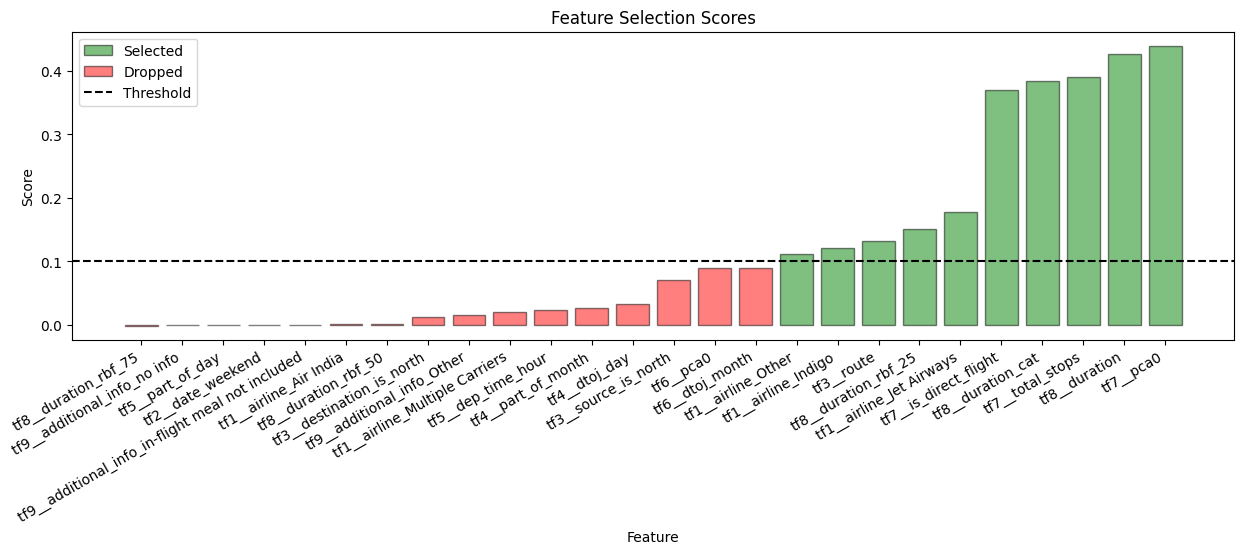

In [33]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
    params = dict(
        x=i,
        height=score,
        edgecolor="black",
        alpha=0.5
    )

    if score < THRESHOLD:
        bar = ax.bar(
            color="red",
            **params
        )
        if not dropped_bar:
            dropped_bar = bar[0]
    else:
        bar = ax.bar(
            color="green",
            **params
        )
        if not selected_bar:
            selected_bar = bar[0]

thresh_line = ax.axhline(
    y=0.1,
    color="black",
    linestyle="--"
)

ax.set_xticks(
    ticks=range(len(sorted_feat_imp)),
    labels=list(sorted_feat_imp.keys()),
    rotation=30,
    ha="right"
)

ax.set(
    xlabel="Feature",
    ylabel="Score",
    title="Feature Selection Scores"
)

ax.legend(
    handles=[selected_bar, dropped_bar, thresh_line],
    labels=["Selected", "Dropped", "Threshold"],
    loc="upper left"
)

plt.show()
